In [3]:
import tensorflow as tf

In [4]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


Here aim is to build a predictive model and find out the sales of each product at a particular store

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import missingno
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from scipy.stats import zscore
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, MinMaxScaler, power_transform
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

#library for error detection in regression models
from sklearn.metrics import mean_squared_error, mean_absolute_error

#libraries for regularisation
from sklearn.linear_model import Ridge,Lasso,RidgeCV,LassoCV

#library for EDA
from scipy.stats import zscore

#Library for saving data
import pickle

#model evaluation
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

#library for GridSearchCV 
from sklearn.model_selection import GridSearchCV
#Library for saving data
import pickle

import warnings
warnings.filterwarnings('ignore')

# Train data

In [2]:
df=pd.read_csv('bigdatamart_Train.csv')
df.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


Here Item_Outlet_Sales is the label which is numerical data, hence we will be doing regression here

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [4]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

12 columns are present

with 5 numerical and 7 string

In [5]:
#finding numerical datas
df.select_dtypes(include=["number"]).columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Outlet_Sales'],
      dtype='object')

In [6]:
#storing the columns 
num=df[{"Item_Weight","Item_Visibility","Item_MRP"}]

In [7]:
#finding categorical datas
df.select_dtypes(exclude=["number"]).columns

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

# EDA

In [8]:
df.describe(include='all')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,7060.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.643456,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.773750,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.850000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


maximum count of columns is 8523

there are null values in Item_Weight and Outlet_Size

In [9]:
#removing duplicates
df.drop_duplicates(inplace = True)

In [10]:
#dropping Item_Identifier because of the high number of unique values,to avoid standardisation error
df=df.drop(columns=["Item_Identifier"])

In [11]:
#checking nan
df.isnull().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

<AxesSubplot:>

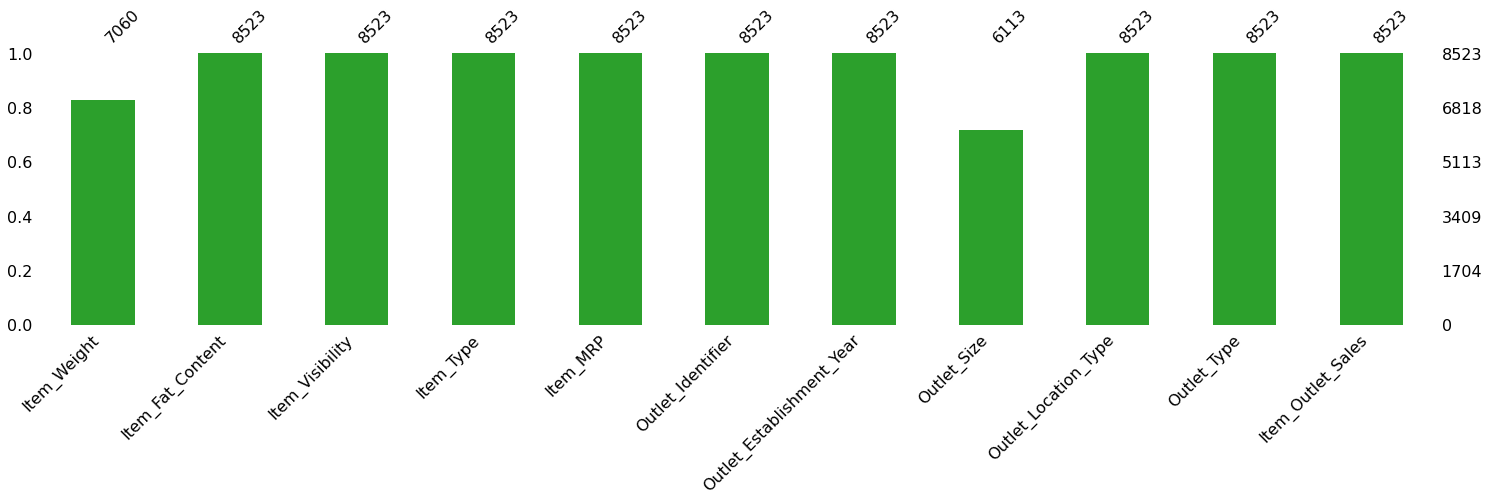

In [12]:
import missingno
missingno.bar(df, figsize = (25,5), color="tab:green")

In [13]:
#dealing with nan value

#removing Item_Weight nan with mean
df["Item_Weight"].fillna(df["Item_Weight"].mean(),inplace=True)

#removing Outlet_Size
df["Outlet_Size"].fillna(df["Outlet_Size"].mode()[0],inplace=True)

In [14]:
#checking nan
df.isnull().sum()

Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

Null values removed

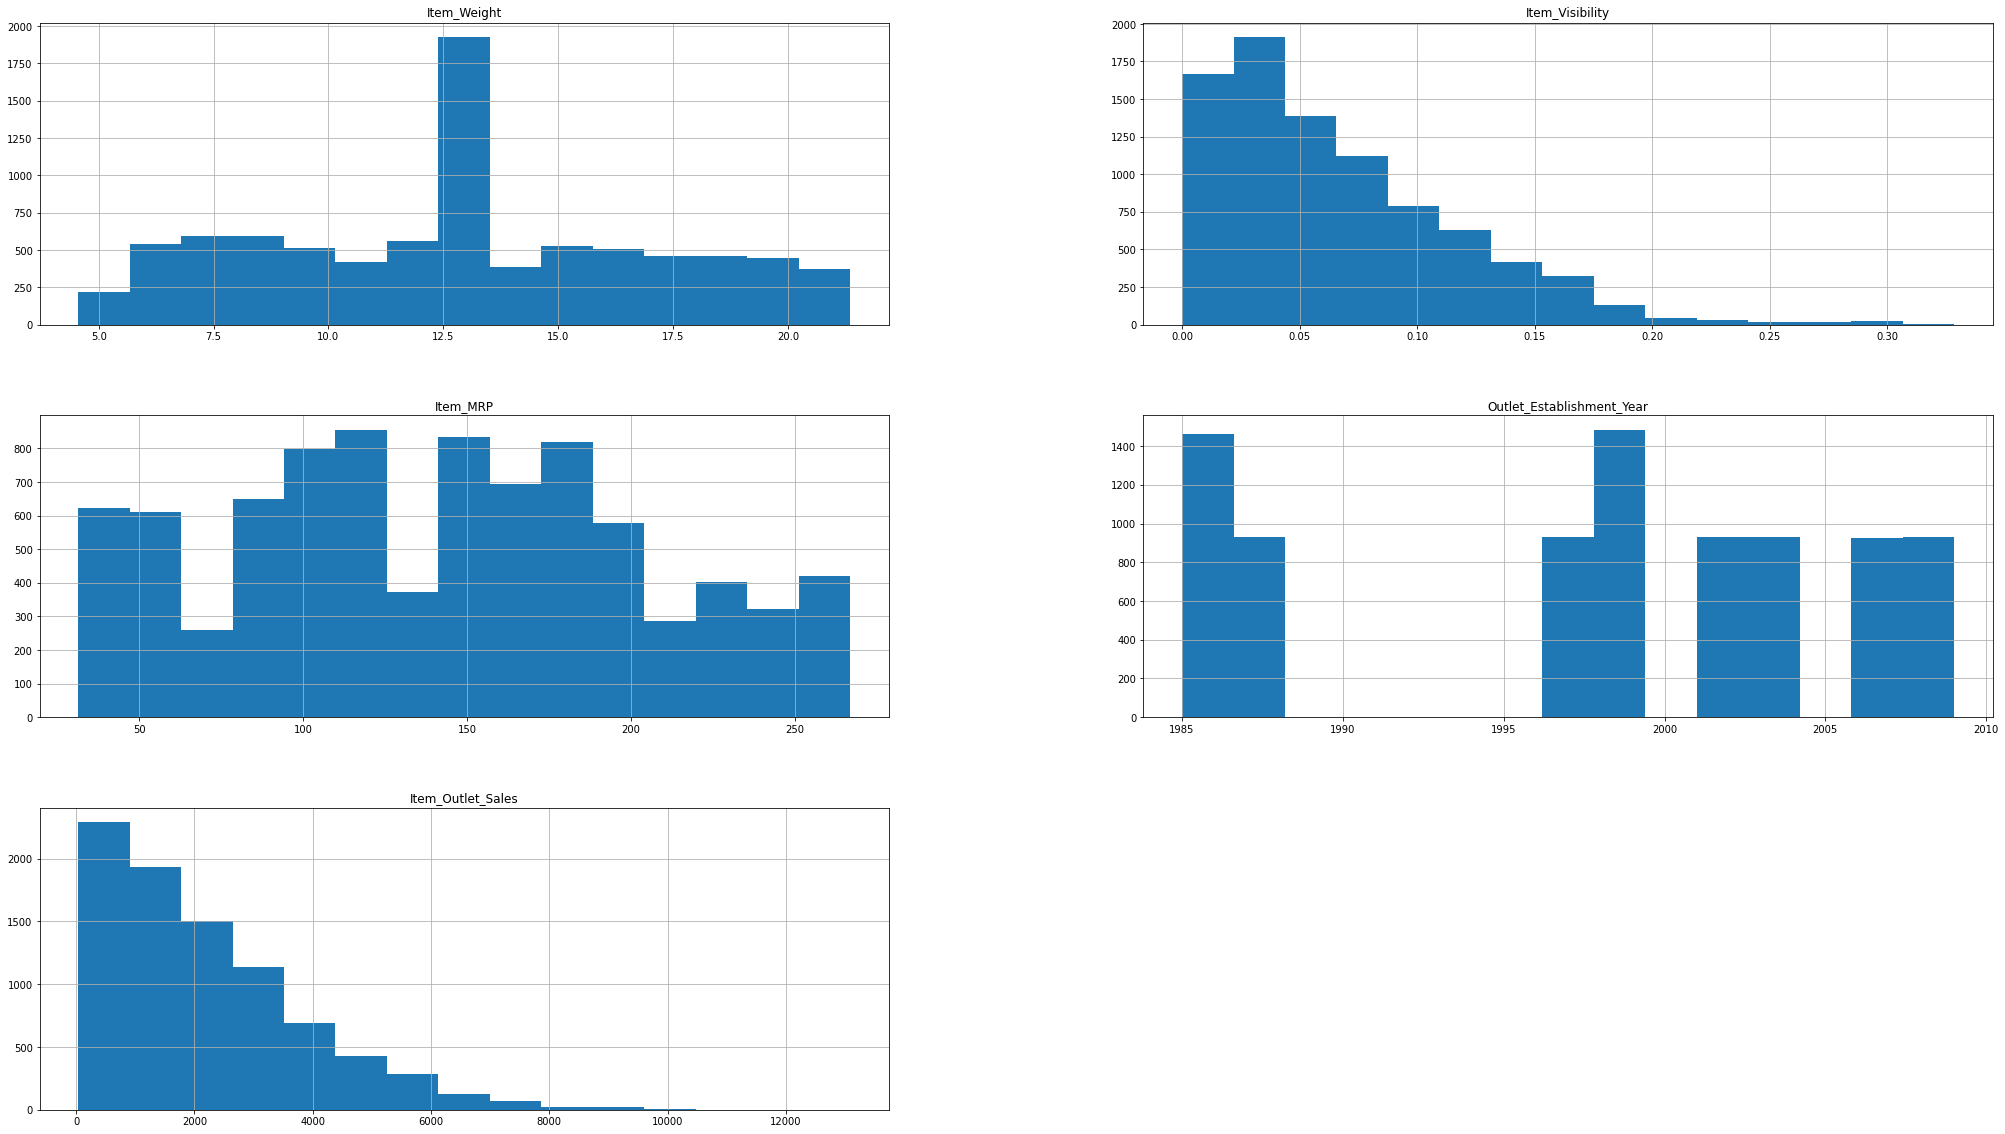

In [15]:
#Checking skewness and outliers
df.hist(figsize=(35,20),bins = 15)
plt.title("Features Distribution")
plt.show()

In [16]:
#storing the columns with outliers
num=df[{"Item_Visibility"}]

In [17]:
#Using zscore
import numpy as np
from scipy.stats import zscore

z=np.abs(zscore(num))
threshold=3
df_new=df[(z<3).all(axis=1)]

print("columns before applying zscore: ",len(df))
print("columns after applying zscore: ",len(df_new))

columns before applying zscore:  8523
columns after applying zscore:  8428


Label or target is Item_Outlet_Sales

Before outliers removed:


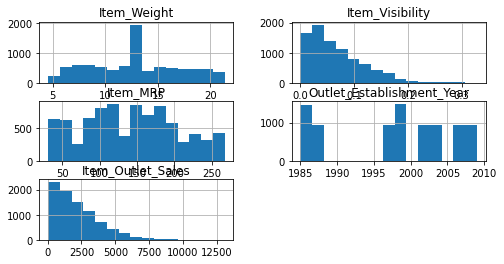

After outliers removed:


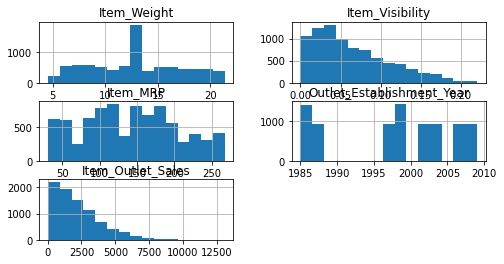

In [18]:
#checking if outliers are removed
print("Before outliers removed:")
df.hist(figsize=(8,4),bins = 15)
plt.title("before outliers removed")
plt.show()

print("After outliers removed:")
df_new.hist(figsize=(8,4),bins = 15)
plt.title("After outliers removed")
plt.show()

In [19]:
#outlet_establishment_year is a string, hence converting it into string
df['Outlet_Establishment_Year'] = df['Outlet_Establishment_Year'].astype('str') 

# Data visualization and analysis

In [20]:
num.head(5)

,Item_Visibility
0,0.016047
1,0.019278
2,0.016760
3,0.000000
4,0.000000


In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   object 
 7   Outlet_Size                8523 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), object(7)
memory usage: 799.0+ KB


**Plots depicting relationship of features with label**

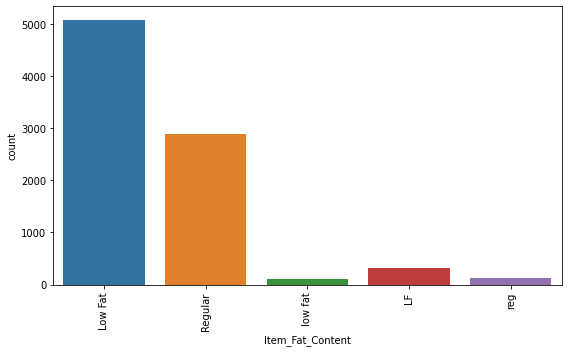

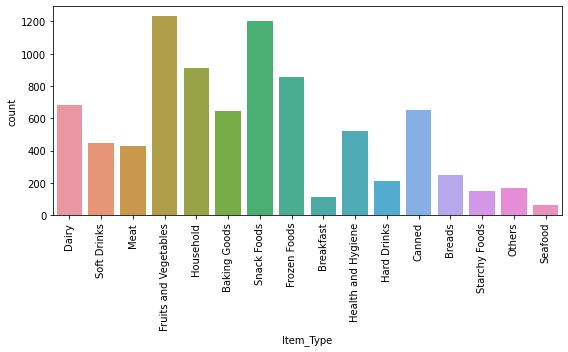

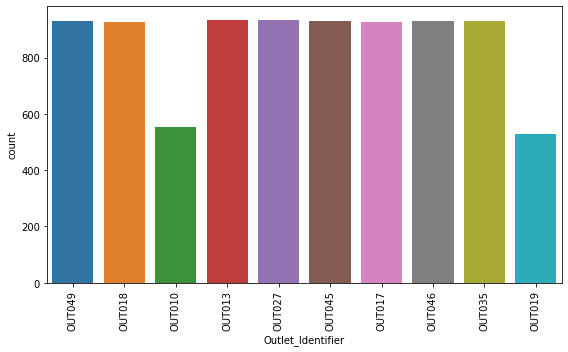

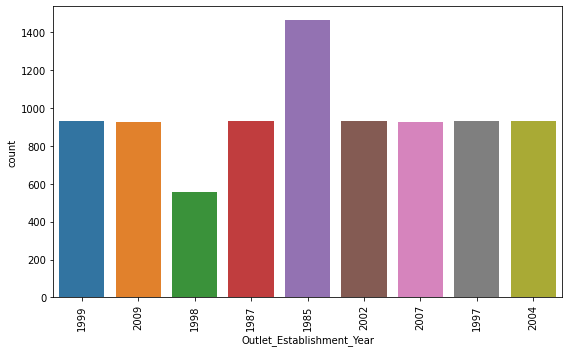

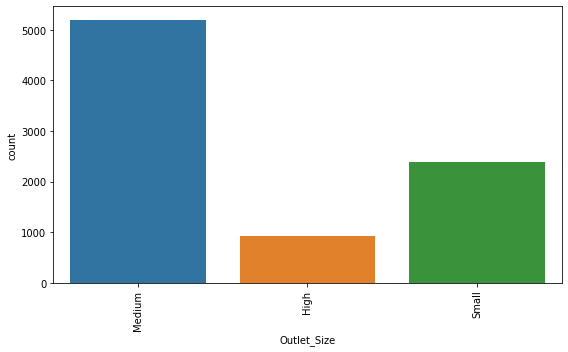

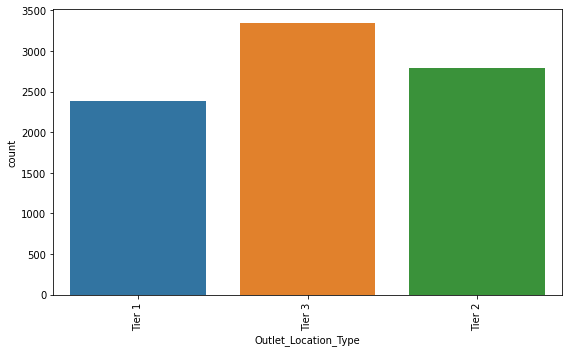

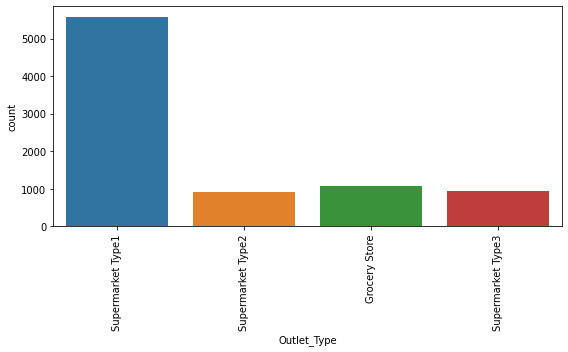

In [22]:
def generate_countplot(x):
    plt.figure(figsize=(8,5))
    sns.countplot(x)
    plt.xticks(rotation=90)
    plt.tight_layout()
    return plt.show()

generate_countplot(df['Item_Fat_Content'])
generate_countplot(df['Item_Type'])
generate_countplot(df['Outlet_Identifier'])
generate_countplot(df['Outlet_Establishment_Year'])
generate_countplot(df['Outlet_Size'])
generate_countplot(df['Outlet_Location_Type'])
generate_countplot(df['Outlet_Type'])


In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   object 
 7   Outlet_Size                8523 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), object(7)
memory usage: 1.1+ MB


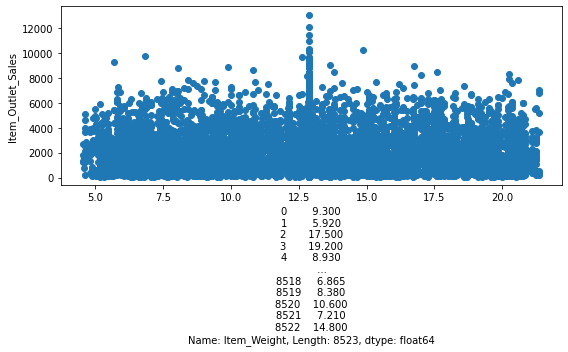

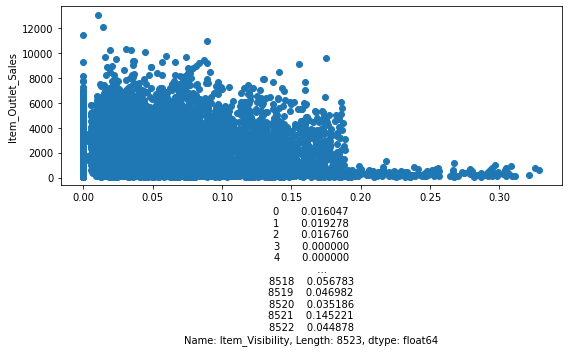

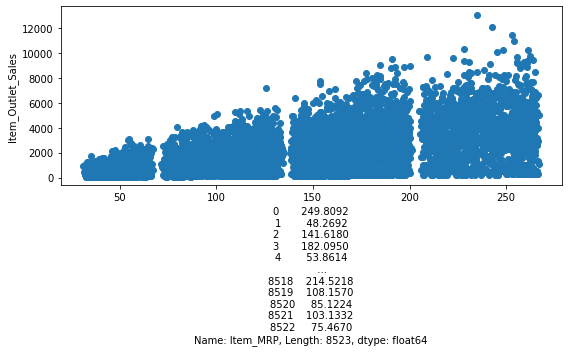

In [24]:
#scatter plots
def scatter_plot(x):
    plt.style.use('fast')
    plt.figure(figsize=(8,5))
    plt.scatter(x, df['Item_Outlet_Sales'])
    plt.xlabel(str(x))
    plt.ylabel("Item_Outlet_Sales")
    plt.tight_layout()
    plt.show()
    
scatter_plot(df['Item_Weight'])
scatter_plot(df['Item_Visibility'])
scatter_plot(df['Item_MRP'])

**Plots depicting relationship of features with labels and each other**

<AxesSubplot:xlabel='Item_Type', ylabel='Item_Outlet_Sales'>

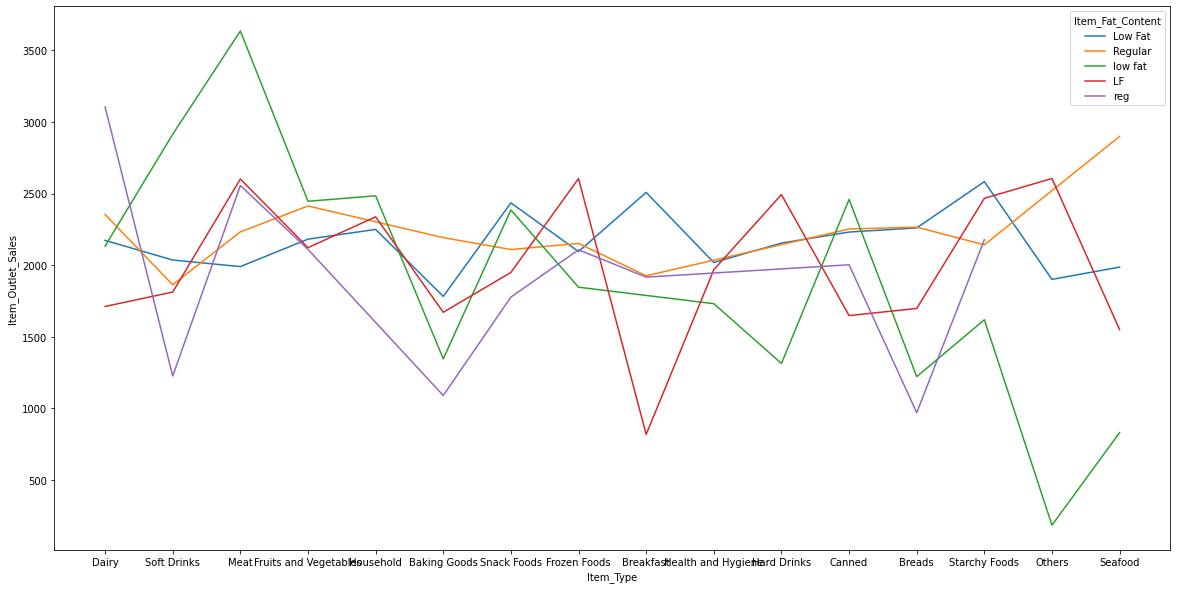

In [25]:
plt.figure(figsize=(20,10))
sns.lineplot(x='Item_Type', y='Item_Outlet_Sales', data=df,hue='Item_Fat_Content' ,ci=None)

<AxesSubplot:xlabel='Item_Type', ylabel='Item_Outlet_Sales'>

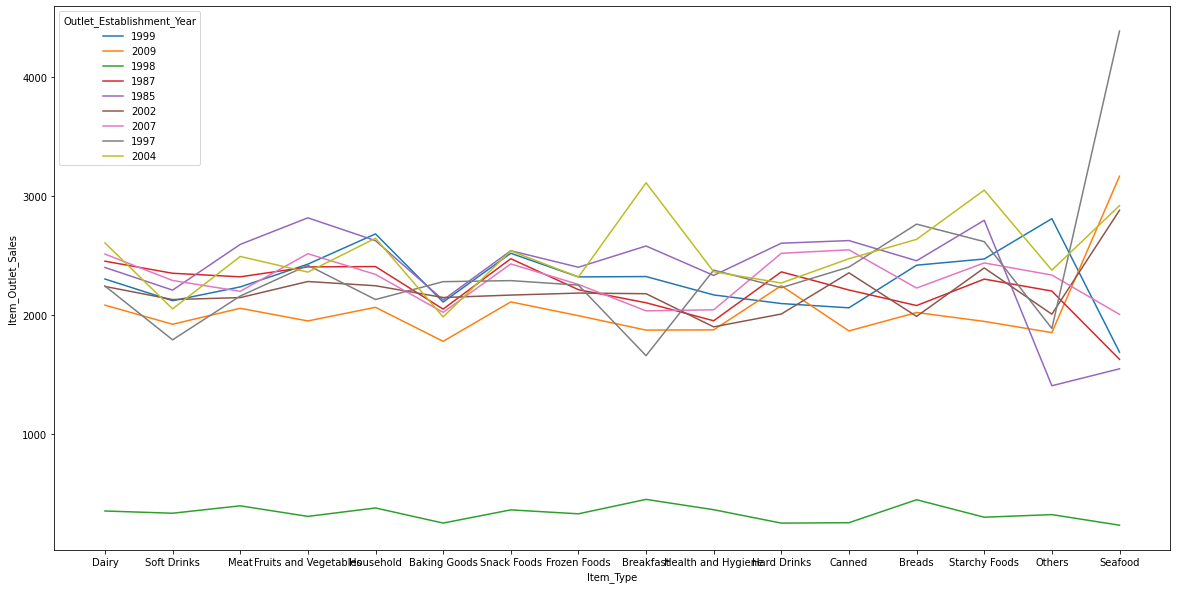

In [26]:
plt.figure(figsize=(20,10))
sns.lineplot(x='Item_Type', y='Item_Outlet_Sales', data=df,hue='Outlet_Establishment_Year' ,ci=None)

<AxesSubplot:xlabel='Item_Type', ylabel='Item_MRP'>

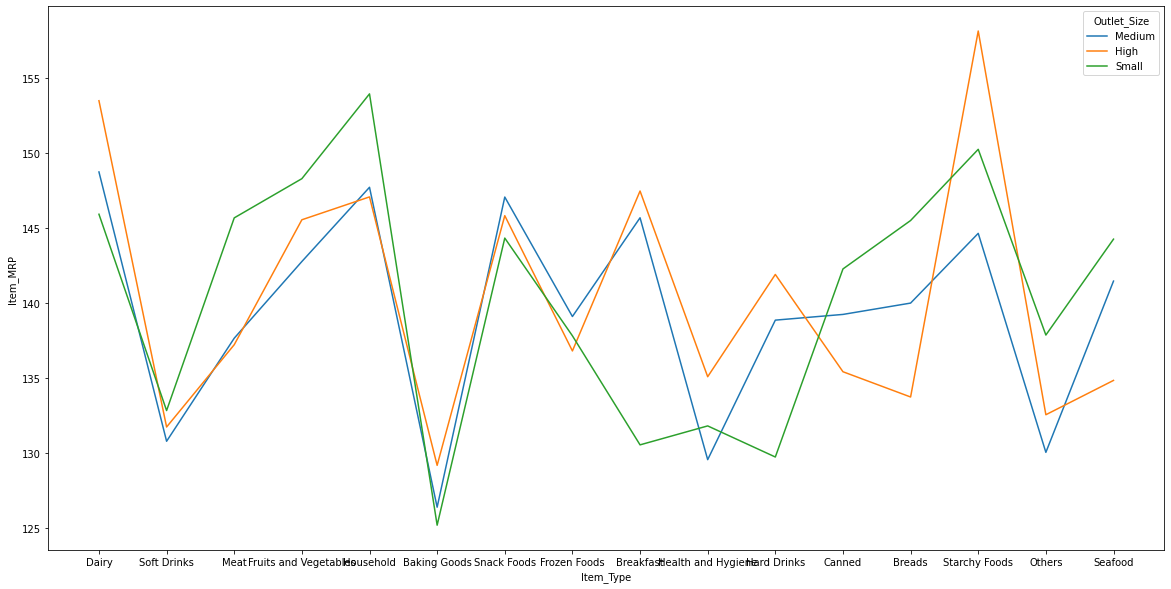

In [27]:
plt.figure(figsize=(20,10))
sns.lineplot(x='Item_Type', y='Item_MRP', data=df,hue='Outlet_Size' ,ci=None)

<AxesSubplot:xlabel='Outlet_Location_Type', ylabel='Item_Outlet_Sales'>

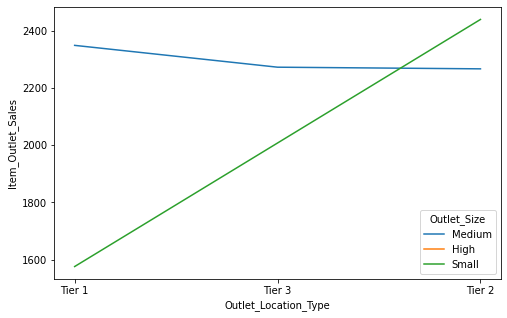

In [28]:
plt.figure(figsize=(8,5))
sns.lineplot(x='Outlet_Location_Type', y='Item_Outlet_Sales', data=df,hue='Outlet_Size' ,ci=None)

<AxesSubplot:xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>

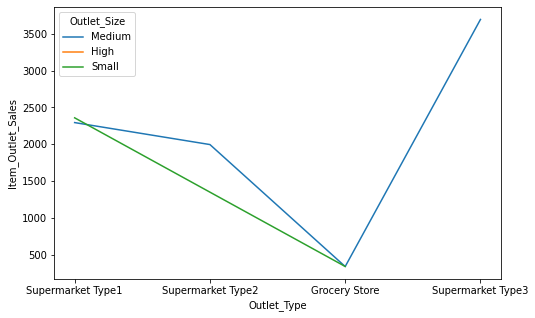

In [29]:
plt.figure(figsize=(8,5))
sns.lineplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df,hue='Outlet_Size' ,ci=None)

<AxesSubplot:xlabel='Outlet_Type', ylabel='Item_Outlet_Sales'>

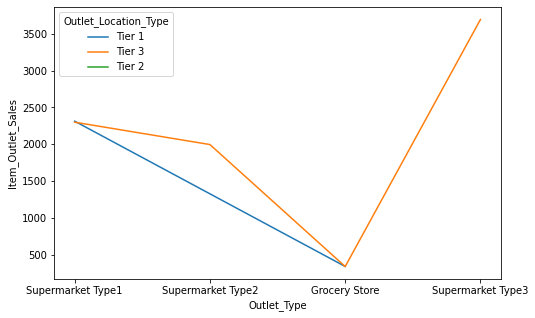

In [30]:
plt.figure(figsize=(8,5))
sns.lineplot(x='Outlet_Type', y='Item_Outlet_Sales', data=df,hue='Outlet_Location_Type' ,ci=None)

# Feature Selection

**1.Comparing features with each other**

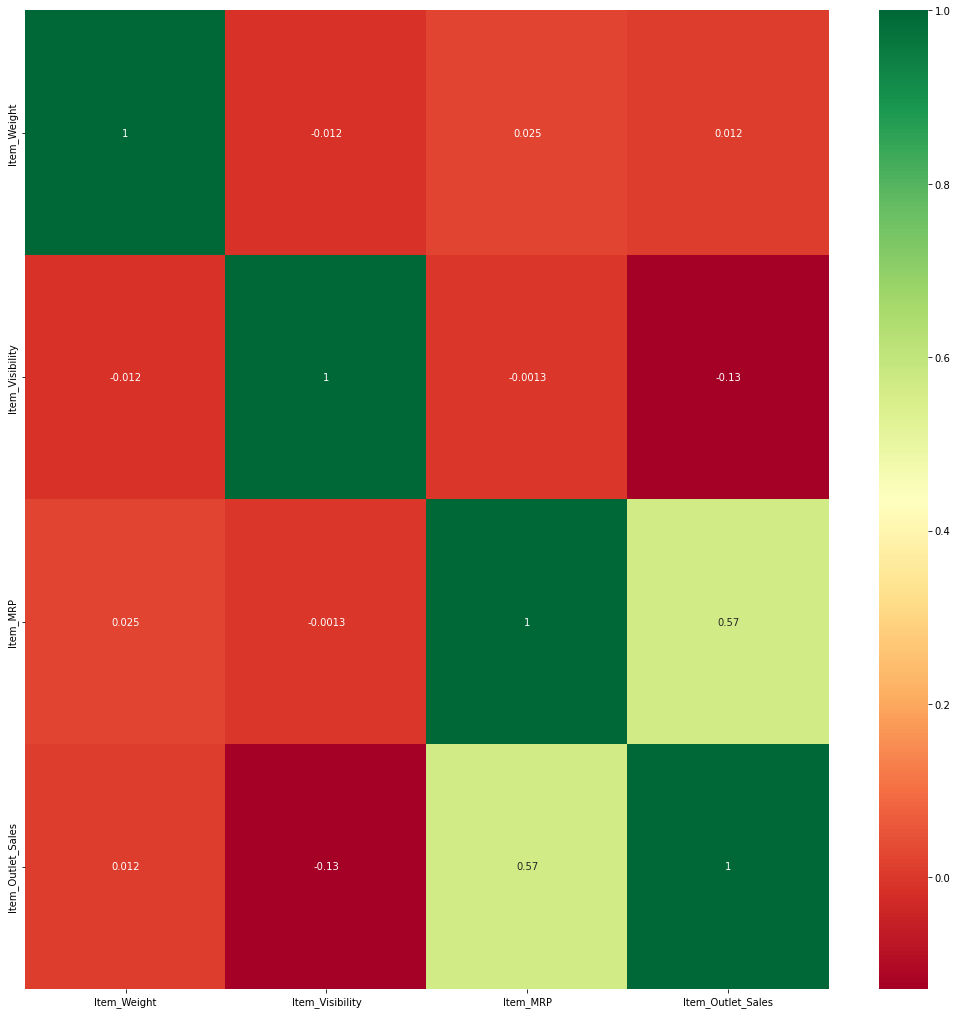

In [31]:
#heatmap
plt.figure(figsize = (18,18))
sns.heatmap(df.corr(), annot = True, cmap = "RdYlGn")
plt.show()

**2.Comparing features with label**

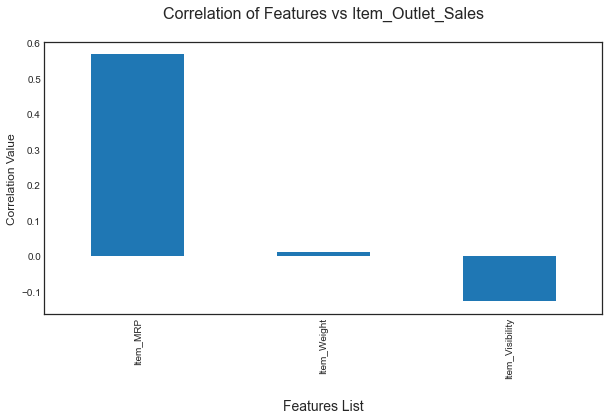

In [32]:
plt.style.use('seaborn-white')
df_corr = df.corr()
plt.figure(figsize=(10,5))
df_corr['Item_Outlet_Sales'].sort_values(ascending=False).drop('Item_Outlet_Sales').plot.bar()
plt.title("Correlation of Features vs Item_Outlet_Sales\n", fontsize=16)
plt.xlabel("\nFeatures List", fontsize=14)
plt.ylabel("Correlation Value", fontsize=12)
plt.show()

# Feature engineering

**1.FEATURE IMPORTANCE**

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Identifier          8523 non-null   object 
 6   Outlet_Establishment_Year  8523 non-null   object 
 7   Outlet_Size                8523 non-null   object 
 8   Outlet_Location_Type       8523 non-null   object 
 9   Outlet_Type                8523 non-null   object 
 10  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), object(7)
memory usage: 1.1+ MB


,Importance
Features,
Item_MRP,0.444
Outlet_Type,0.247
Item_Visibility,0.107
Item_Weight,0.059
Item_Type,0.050
Outlet_Establishment_Year,0.045
Item_Fat_Content,0.017
Outlet_Identifier,0.016
Outlet_Size,0.008


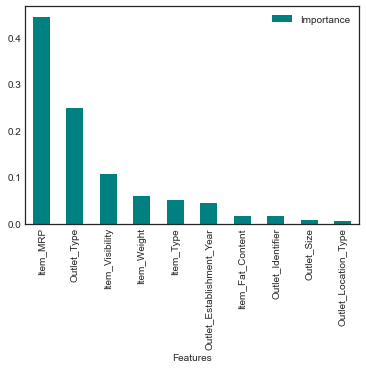

In [34]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

x1=df.drop(columns=["Item_Outlet_Sales"])
y=df['Item_Outlet_Sales']

from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
x1['Item_Fat_Content']= label_encoder.fit_transform(x1['Item_Fat_Content'])
x1['Item_Type']= label_encoder.fit_transform(x1['Item_Type'])
x1['Outlet_Identifier']= label_encoder.fit_transform(x1['Outlet_Identifier'])
x1['Outlet_Establishment_Year']= label_encoder.fit_transform(x1['Outlet_Establishment_Year'])
x1['Outlet_Size']= label_encoder.fit_transform(x1['Outlet_Size'])
x1['Outlet_Location_Type']= label_encoder.fit_transform(x1['Outlet_Location_Type'])
x1['Outlet_Type']= label_encoder.fit_transform(x1['Outlet_Type'])

x_train, x_test,y_train, y_test=train_test_split(x1,y,test_size=.25,random_state=199)
rf=RandomForestRegressor()
rf.fit(x_train, y_train)
importances = pd.DataFrame({'Features':x1.columns, 'Importance':np.round(rf.feature_importances_,3)})
importances = importances.sort_values('Importance', ascending=False).set_index('Features')
importances.plot.bar(color='teal')
importances

Item MRP has highest relation to the Sales

**2.Encoding the data**

In [35]:
x=df.drop(columns=["Item_Outlet_Sales"])
y=df['Item_Outlet_Sales']

In [36]:
#encoding
import pandas as pd
df=pd.get_dummies(df)

**3.Reduced Order Modelling on the encoded data**

    Applying proper orthogonal decomposition to reduce the order of the model

In [37]:
df.head()

,Item_Weight,Item_Visibility,Item_MRP,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,3735.1380,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,443.4228,0,0,1,0,0,0,...,0,1,0,0,0,1,0,0,1,0
2,17.50,0.016760,141.6180,2097.2700,0,1,0,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,19.20,0.000000,182.0950,732.3800,0,0,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0
4,8.93,0.000000,53.8614,994.7052,0,1,0,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [38]:
#standardising the data for PCA
x=df.drop(columns=["Item_Outlet_Sales"])

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaledX=scaler.fit_transform(x)

In [39]:
#PCA

from sklearn.decomposition import PCA

testpca=PCA()
Y=testpca.fit(scaledX)

var_cumu=np.cumsum(Y.explained_variance_ratio_)*100
var_cumu

array([ 10.05246262,  17.86340661,  25.30753778,  31.5605667 ,
        37.53203025,  42.9996886 ,  47.24835278,  51.48737879,
        55.61188056,  59.11680573,  61.39851906,  63.60658306,
        65.74762415,  67.87385451,  69.97647793,  72.04911193,
        74.1011649 ,  76.13809581,  78.16929598,  80.16304219,
        82.13493314,  84.07868808,  86.01499635,  87.94691261,
        89.84717579,  91.7186053 ,  93.5708297 ,  95.31774919,
        97.015648  ,  98.6211551 , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        , 100.        , 100.        , 100.        ,
       100.        ])

In [40]:
# PCs explaines 95% of the variance?

k=np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: ",k)

Number of components explaining 95% variance:  27


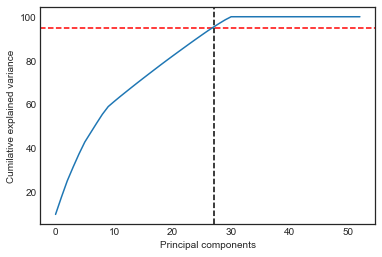

In [41]:
plt.ylabel('Cumilative explained variance')
plt.xlabel('Principal components')
plt.axvline(x=k,color='k',linestyle='--')
plt.axhline(y=95,color='r',linestyle='--')

plt.plot(var_cumu)
plt.show()

In [42]:
# Creating final dataset with 30 columns

FinalPCA=PCA(n_components=28)
FinalData=FinalPCA.fit_transform(scaledX)

FinalData2=pd.DataFrame(FinalData)
FinalData2

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-1.008855,0.164561,-0.976274,1.655091,3.719835,-0.027685,-0.288805,-2.390270,-0.941460,-0.124227,...,-0.107227,-0.034505,0.475062,-0.191536,-0.394331,-0.523936,0.292635,-0.715422,0.751262,1.481101
1,3.692988,-1.187142,-0.221728,3.726842,-1.760187,-0.304729,0.318966,-0.000223,1.138858,0.328147,...,-2.224809,-2.074033,-0.086976,-0.334788,-1.082411,-0.958198,-0.267582,1.008753,-0.457657,-0.105027
2,-0.945766,0.194790,-1.019545,1.605468,3.734846,-0.055117,-0.141434,-2.431301,-0.587472,-0.262587,...,-2.147248,0.538584,1.913473,0.894320,-0.569516,-0.175411,-0.250597,0.562553,0.449919,-0.242342
3,2.818000,1.077965,-0.867095,-1.662699,-0.135987,4.744182,0.384966,-0.067396,1.612833,-2.473035,...,-0.125811,0.299662,-0.438173,0.440240,-0.121896,-0.434181,-0.048324,0.296520,-0.551100,0.228246
4,0.319075,0.051472,5.593951,-0.480715,0.705889,0.045214,-0.503120,0.087526,-1.818453,0.313096,...,-0.300214,0.311843,-0.379874,-0.021398,-0.337216,-0.226015,-0.219178,0.162960,0.267683,-0.988717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8518,0.343607,0.139705,5.514823,-0.530461,0.659601,0.184722,-0.231311,-0.037067,-0.659279,0.491422,...,-0.377964,-0.042221,-0.083839,-0.100278,-0.024492,0.060877,0.315162,-0.706528,0.277281,1.077439
8519,-1.152703,-2.923782,-0.838778,-0.822842,0.397449,0.246221,-2.538218,1.244029,2.821010,0.455350,...,0.208697,-0.020102,-0.357430,0.016309,-0.214294,-0.110084,0.267507,-0.506678,-0.278591,0.932383
8520,-2.947705,-0.351640,0.048771,-0.612269,-3.268262,-0.474916,-0.484634,-2.297894,-1.875728,-0.712381,...,0.356054,1.138423,-0.740667,-1.199685,-0.642719,0.481130,-0.024989,-0.325739,0.084809,0.404966
8521,3.784155,-0.944558,-0.355923,3.588361,-1.815500,0.056712,0.477621,-0.118000,1.875248,0.653903,...,-0.340201,-0.185958,-0.465154,-0.019007,0.023036,0.302492,0.030374,-0.421530,0.000941,-0.535009


In [43]:
x=FinalData2

**4.Feature Scaling of input variable**

In [44]:
scaler = StandardScaler()
x = pd.DataFrame(scaler.fit_transform(x), columns=x.columns)
x.head() # Displaying all the features after applying scaling technique to avoid bias output

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.437074,0.080879,-0.491503,0.909157,2.090958,-0.016263,-0.192460,-1.594689,-0.636764,-0.091146,...,-0.103345,-0.033567,0.464698,-0.188709,-0.389256,-0.517781,0.291596,-0.718352,0.758240,1.539254
1,1.599940,-0.583462,-0.111629,2.047188,-0.989419,-0.179009,0.212559,-0.000149,0.770275,0.240763,...,-2.144265,-2.017636,-0.085079,-0.329846,-1.068481,-0.946942,-0.266632,1.012885,-0.461908,-0.109150
2,-0.409741,0.095736,-0.513288,0.881898,2.099396,-0.032378,-0.094252,-1.622063,-0.397341,-0.192662,...,-2.069512,0.523939,1.871729,0.881119,-0.562187,-0.173350,-0.249707,0.564858,0.454098,-0.251857
3,1.220863,0.529804,-0.436538,-0.913336,-0.076440,2.786909,0.256542,-0.044964,1.090852,-1.814483,...,-0.121256,0.291514,-0.428614,0.433742,-0.120327,-0.429081,-0.048153,0.297735,-0.556219,0.237208
4,0.138235,0.025298,2.816266,-0.264061,0.396787,0.026560,-0.335280,0.058394,-1.229924,0.229721,...,-0.289345,0.303363,-0.371587,-0.021083,-0.332877,-0.223359,-0.218400,0.163628,0.270170,-1.027537


Using the StandardScaler method to normalize the feature values and ensure that the regression model does not have any kind of biasness towards a particular column value

**5.Applying log transform on output variable if skewness is present**

<AxesSubplot:title={'center':'Normal Distribution'}, xlabel='Item_Outlet_Sales', ylabel='Density'>

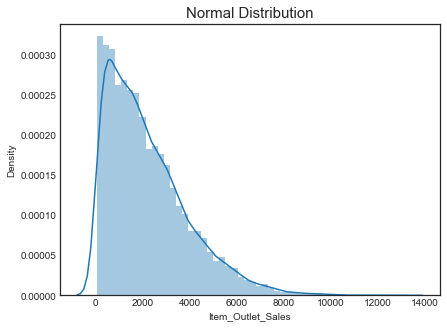

In [45]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.title("Normal Distribution",fontsize=15)
sns.distplot(y)

Skewness is present, hence applying log transform

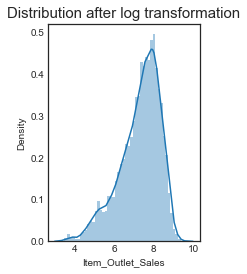

In [46]:
#Applying log transform
y1=np.log(y)
plt.subplot(1,2,2)
plt.title("Distribution after log transformation",fontsize=15)
sns.distplot(y1)
plt.show()

**6.Splitting data into train, test and validation data**

**a.Finding the best random state**

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
maxAccu=0
maxRS=0

for i in range(1,200):
    x_train, x_test,y_train, y_test=train_test_split(x,y,test_size=.25,random_state=i)
    LR=LinearRegression()
    LR.fit(x_train,y_train)
    predrf=LR.predict(x_test)
    r2=r2_score(y_test,predrf)
    if r2>maxAccu:
        maxr2=r2
        maxRS=i

print("Best r2 score is", maxr2,"on Random State",maxRS)

Best r2 score is 0.5243374088011052 on Random State 199


**b.splitting the data**

In [48]:
#splitting the data into train and test
from sklearn.model_selection import train_test_split

# In the first step we will split the data in training and remaining dataset
X_train, X_rem, Y_train, Y_rem = train_test_split(x,y, train_size=0.8,random_state=199)

# Now since we want the valid and test size to be equal (10% each of overall data). 
# we have to define valid_size=0.5 (that is 50% of remaining data)
test_size = 0.5
X_valid, X_test, Y_valid, Y_test = train_test_split(X_rem,Y_rem, test_size=0.5)

In [49]:
print(X_train.shape), print(Y_train.shape)
print(X_valid.shape), print(Y_valid.shape)
print(X_test.shape), print(Y_test.shape)

(6818, 28)
(6818,)
(852, 28)
(852,)
(853, 28)
(853,)


(None, None)

# Testing various models

In [50]:
LR=LinearRegression()
RR=Ridge(alpha=1e-2, normalize=True)
LasR=Lasso(alpha=1e-2, normalize=True, max_iter=1e5)
svr=SVR(C=1.0, epsilon=0.2, kernel='poly', gamma='auto')
DTR=DecisionTreeRegressor(criterion="poisson", random_state=111)
RFR=RandomForestRegressor(max_depth=2, max_features="sqrt")
KNR=KNeighborsRegressor(n_neighbors=2, algorithm='kd_tree')
GBR=GradientBoostingRegressor(loss='quantile', n_estimators=200, max_depth=5)
ABR=AdaBoostRegressor(n_estimators=300, learning_rate=1.05, random_state=42)
ETR=ExtraTreesRegressor(n_estimators=200, max_features='sqrt', n_jobs=6)
XGBR=XGBRegressor()
LGBR=LGBMRegressor()


models= []
models.append(('LinearRegression', LR))
models.append(('Ridge Regressor', RR))
models.append(('Lasso Regressor', LasR))
models.append(('SVR',svr))
models.append(('DecisionTreeRegressor',DTR))
models.append(('RandomForestRegressor',RFR))
models.append(('KNeighborsRegressor',KNR))
models.append(('GradientBoostingRegressor',GBR))
models.append(('AdaBoostRegressor',ABR))
models.append(('ExtraTreesRegressor',ETR))
models.append(('XGBRegressor',XGBR))
models.append(('LGBMRegressor',LGBR))

In [51]:
Model= []
score= []
cvs=[]
difference=[]
RMSE=[]


****************************************** LinearRegression ********************************************************


LinearRegression()


R2 Score is: 52.51992488006074


Cross Validation Score: 46.14172347305245


R2 Score - Cross Validation Score is 6.378201407008291
RMSE Score is: 1180.001364172507


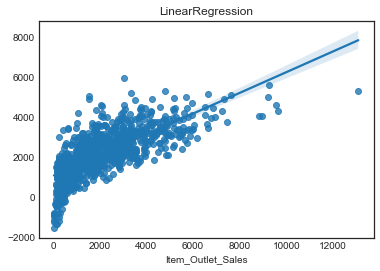

****************************************** Ridge Regressor ********************************************************


Ridge(alpha=0.01, normalize=True)


R2 Score is: 52.496630894817095


Cross Validation Score: 46.24385553488439


R2 Score - Cross Validation Score is 6.252775359932706
RMSE Score is: 1180.2907862491531


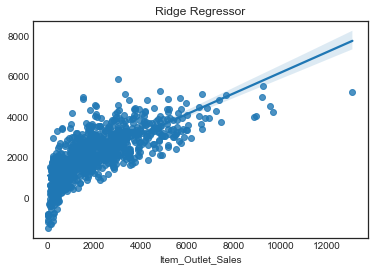

****************************************** Lasso Regressor ********************************************************


Lasso(alpha=0.01, max_iter=100000.0, normalize=True)


R2 Score is: 52.51852265956634


Cross Validation Score: 46.160387182633166


R2 Score - Cross Validation Score is 6.358135476933171
RMSE Score is: 1180.018788427585


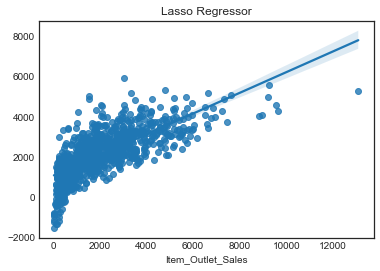

****************************************** SVR ********************************************************


SVR(epsilon=0.2, gamma='auto', kernel='poly')


R2 Score is: -3.173331521144873


Cross Validation Score: -5.817064625125732


R2 Score - Cross Validation Score is 2.6437331039808587
RMSE Score is: 1739.4443457372029


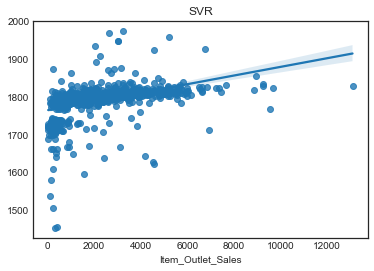

****************************************** DecisionTreeRegressor ********************************************************


DecisionTreeRegressor(criterion='poisson', random_state=111)


R2 Score is: -15.247387779224564


Cross Validation Score: -43.22075423354821


R2 Score - Cross Validation Score is 27.97336645432365
RMSE Score is: 1838.4099245712518


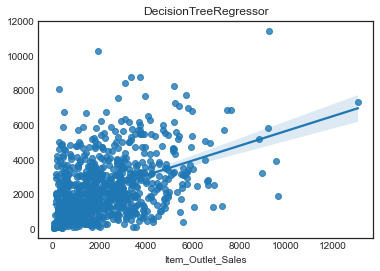

****************************************** RandomForestRegressor ********************************************************


RandomForestRegressor(max_depth=2, max_features='sqrt')


R2 Score is: 27.442142533190705


Cross Validation Score: 23.940411648407796


R2 Score - Cross Validation Score is 3.5017308847829085
RMSE Score is: 1458.710253703298


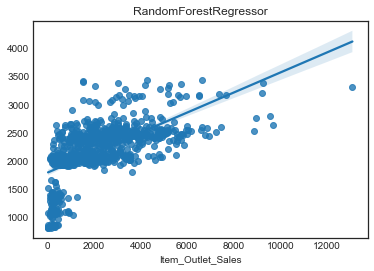

****************************************** KNeighborsRegressor ********************************************************


KNeighborsRegressor(algorithm='kd_tree', n_neighbors=2)


R2 Score is: 34.703647561289316


Cross Validation Score: 7.176171386743993


R2 Score - Cross Validation Score is 27.52747617454532
RMSE Score is: 1383.793452752554


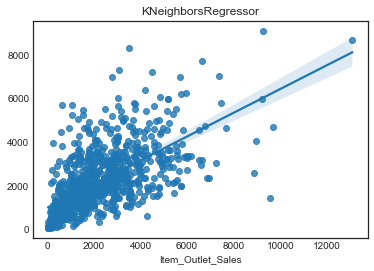

****************************************** GradientBoostingRegressor ********************************************************


GradientBoostingRegressor(loss='quantile', max_depth=5, n_estimators=200)


R2 Score is: 3.352981226262919


Cross Validation Score: -1.8262793241723176


R2 Score - Cross Validation Score is 5.179260550435236
RMSE Score is: 1683.5307052851217


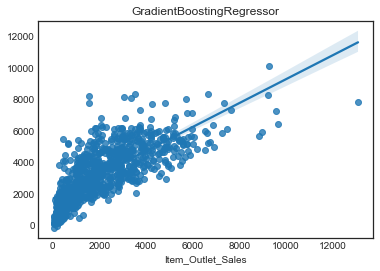

****************************************** AdaBoostRegressor ********************************************************


AdaBoostRegressor(learning_rate=1.05, n_estimators=300, random_state=42)


R2 Score is: -33.34192211933009


Cross Validation Score: 27.487497087070263


R2 Score - Cross Validation Score is -60.82941920640036
RMSE Score is: 1977.4711961155415


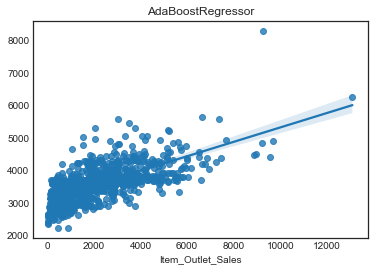

****************************************** ExtraTreesRegressor ********************************************************


ExtraTreesRegressor(max_features='sqrt', n_estimators=200, n_jobs=6)


R2 Score is: 48.69787284689068


Cross Validation Score: 45.47528450988711


R2 Score - Cross Validation Score is 3.2225883370035717
RMSE Score is: 1226.5760969281407


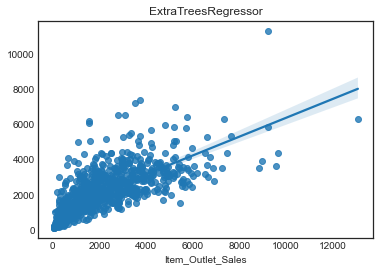

****************************************** XGBRegressor ********************************************************


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)


R2 Score is: 52.15914885689381


Cross Validation Score: 42.14717207515041


R2 Score - Cross Validation Score is 10.0119767817434
RMSE Score is: 1184.475983875467


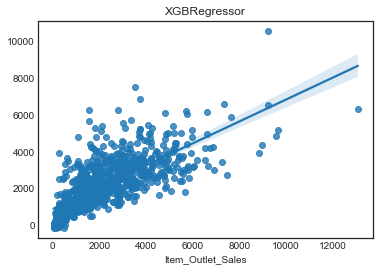

****************************************** LGBMRegressor ********************************************************


LGBMRegressor()


R2 Score is: 57.31359483670697


Cross Validation Score: 46.199428154477616


R2 Score - Cross Validation Score is 11.114166682229353
RMSE Score is: 1118.8493188150162


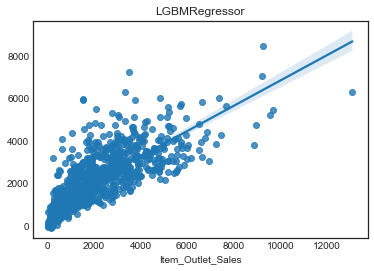

In [52]:
for name,model in models:
    print('******************************************',name,'********************************************************')
    
    print('\n')
    Model.append(name)
    
    # Training the model
    model.fit(X_train, Y_train) #computer learing
    
    print(model)
    
     # Predicting Y_test
    pred = model.predict(X_test)  #testing
    
    print('\n') 
    
    # R2 score
    r2 = r2_score(Y_test, pred, multioutput='variance_weighted')*100
    print("R2 Score is:", r2)
    score.append(r2)
    print('\n')
    
    # Cross Validation Score
    cv_score = (cross_val_score(model,X_valid,Y_valid, cv=5).mean())*100
    print("Cross Validation Score:", cv_score)
    cvs.append(cv_score)
    print('\n')
    
    # Result of r2 score minus cv score
    result = r2 - cv_score
    print("R2 Score - Cross Validation Score is", result)
    difference.append(result)
    
     # RMSE - a lower RMSE score is better than a higher one
    rmse = mean_squared_error(Y_test, pred, squared=False)
    print("RMSE Score is:", rmse)
    RMSE.append(rmse)
    
    #plots created
    sns.regplot(Y_test,pred)
    plt.title(name)
    plt.show()

In [53]:
result = pd.DataFrame({'Model': Model, 'r2score': score,'Cross_val_score': cvs,'RMSE score':RMSE,'Difference between cv score and cross_val score':difference})
result

,Model,r2score,Cross_val_score,RMSE score,Difference between cv score and cross_val score
0,LinearRegression,52.519925,46.141723,1180.001364,6.378201
1,Ridge Regressor,52.496631,46.243856,1180.290786,6.252775
2,Lasso Regressor,52.518523,46.160387,1180.018788,6.358135
3,SVR,-3.173332,-5.817065,1739.444346,2.643733
4,DecisionTreeRegressor,-15.247388,-43.220754,1838.409925,27.973366
5,RandomForestRegressor,27.442143,23.940412,1458.710254,3.501731
6,KNeighborsRegressor,34.703648,7.176171,1383.793453,27.527476
7,GradientBoostingRegressor,3.352981,-1.826279,1683.530705,5.179261
8,AdaBoostRegressor,-33.341922,27.487497,1977.471196,-60.829419
9,ExtraTreesRegressor,48.697873,45.475285,1226.576097,3.222588


# Selection of best model

Some models with good r2 score and least difference between r2 score and cross val is :

1. XGB booster 
2. Linear regression
3. Ridge regression
4. Lasso regression

Among these **XGB Booster is the best**.It is one of the most popular models used in Kaggle competitions that deal with structured datasets (think of the sort of data you might keep in an Excel file). Not only does it require little computational time and power, but it has also consistently proved that it’s very accurate
Further it has low score between r2score and cross_val

Ridge regressor is best used:where large multicollinarity exists in the data
where observations are fewer than predictor variables, ridge regression is the most appropriate technique. but here there is not large mulitcollinearity

# HYPER-PARAMETER TUNING 
**Using gridsearch cv to find the best parameters in best model**

In [61]:
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [63]:
!nvidia-smi

Thu Dec  2 13:05:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 472.47       Driver Version: 472.47       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   39C    P8     3W /  N/A |    134MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [71]:
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('\n Time taken: %i hours %i minutes and %s seconds.' % (thour, tmin, round(tsec, 2)))

In [72]:
params= {'booster' : ['gbtree','dart','gblinear'],
              'importance_type' : ['gain','split'],
              'n_estimators' : [100,200,500],
              'eta' : [0.001, 0.01, 0.1]
             }


In [73]:
GSCV = GridSearchCV(XGBRegressor(tree_method='gpu_hist'), param, cv=5)

start_time = timer(None)
GSCV.fit(X_train,Y_train)
timer(start_time)

GSCV.best_params_

[14:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This c

[14:30:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:19] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This c

[14:30:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This c

[14:30:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This c

[14:30:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[14:30:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "tree_method" } might not be used.

  This c

{'booster': 'gbtree',
 'eta': 0.01,
 'importance_type': 'gain',
 'n_estimators': 500}

In [74]:
Final_Model = XGBRegressor(booster='gbtree', eta=0.1, importance_type='gain', n_estimators=200,tree_method='gpu_hist')
regressor = Final_Model.fit(X_train, Y_train)
fmod_pred = Final_Model.predict(X_test)
fmod_r2 = r2_score(Y_test, fmod_pred)*100
print("R2 score for the Best Model is:", fmod_r2)

R2 score for the Best Model is: 55.11964696463909


In [76]:
#Saving the best Regression ML model
import joblib as joblib

filename = "FinalModel_Bigdatamart.pkl"
joblib.dump(Final_Model, filename)

['FinalModel_Bigdatamart.pkl']

-----------------------------------------------------Model development complete------------------------------------------------------

# Applying the model on test data

In [78]:
df_test=pd.read_csv('bigdatamart_Test.csv')

#removing duplicates
df_test.drop_duplicates(inplace = True)

df_test.head(5)

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [79]:
#dropping Item_Identifier because of the high number of unique values,to avoid standardisation error
df_test=df_test.drop(columns=["Item_Identifier"])

In [80]:
#checking nan
df_test.isnull().sum()

Item_Weight                   976
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  1606
Outlet_Location_Type            0
Outlet_Type                     0
dtype: int64

In [81]:
#dealing with nan value
#removing Item_Weight nan with mean
df_test["Item_Weight"].fillna(df_test["Item_Weight"].mean(),inplace=True)

#removing Outlet_Size
df_test["Outlet_Size"].fillna(df_test["Outlet_Size"].mode()[0],inplace=True)

#dealing with outliers

#storing the columns with outliers
num=df_test[{"Item_Visibility"}]
#Using zscore
import numpy as np
from scipy.stats import zscore

z=np.abs(zscore(num))
threshold=3
df_new=df_test[(z<3).all(axis=1)]

df_test=df_new

#outlet_establishment_year is a string, hence converting it into string
df_test['Outlet_Establishment_Year'] = df_test['Outlet_Establishment_Year'].astype('str') 

In [82]:
#encoding
import pandas as pd
df=pd.get_dummies(df_test)

#standardising the data for PCA
x=df

from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
scaledX=scaler.fit_transform(x)

#PCA

from sklearn.decomposition import PCA
testpca=PCA()
Y=testpca.fit(scaledX)
var_cumu=np.cumsum(Y.explained_variance_ratio_)*100

# PCs explaines 95% of the variance?
k=np.argmax(var_cumu>95)
print("Number of components explaining 95% variance: ",k)

Number of components explaining 95% variance:  27


In [83]:
# Creating final dataset with 30 columns

FinalPCA=PCA(n_components=28)
FinalData=FinalPCA.fit_transform(scaledX)

FinalData2=pd.DataFrame(FinalData)
FinalData2

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,-0.988099,0.018479,-1.100649,1.718666,3.676607,-0.131743,-0.924862,-2.252803,0.253852,-0.290442,...,-0.385159,-0.474032,0.029919,0.025221,0.330595,-0.194824,-0.019233,0.086497,-0.075606,0.382337
1,-1.172260,-3.025001,-0.063323,-0.733198,0.499525,0.091763,-1.892301,2.103227,-2.160506,0.422645,...,-0.827424,-3.143979,-0.212967,-2.202835,-1.065872,0.301208,-1.783707,3.316761,4.199924,0.697876
2,2.863246,0.936876,-1.150616,-1.734814,-0.129636,5.445578,-1.152781,-0.176684,1.653754,-2.083607,...,0.176568,-0.732538,-1.423844,-0.851561,5.093598,2.054112,0.567777,-1.702284,1.260681,-1.599117
3,-1.122057,-3.068602,-0.108342,-0.621798,0.499727,0.151135,-2.791584,2.119188,-0.693129,0.360500,...,0.103183,-0.234996,0.125916,-0.643666,-0.099191,-0.160818,-0.064804,-0.314009,-0.426455,0.672334
4,3.270657,0.691509,-1.185167,-2.830281,0.330489,-2.772101,0.916282,0.096949,-1.493716,-0.862947,...,0.405448,-0.453275,0.569981,-0.152486,-0.164696,-0.195249,0.144701,-0.549036,-0.262591,-0.544013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5595,-2.784876,2.826130,-0.795954,1.650576,-0.098650,-0.600877,1.484393,2.423914,-1.159949,-1.418601,...,-0.004199,-0.184288,0.162013,-0.388417,0.106206,-0.164097,0.088108,-0.484597,-0.504664,0.442684
5596,3.815422,-0.888711,-0.162579,3.483804,-1.848694,-0.048323,1.007123,0.155455,-1.575784,0.535678,...,0.285364,2.177746,-1.184525,2.466996,-1.272159,5.091949,-0.617459,1.057991,-0.261666,2.037074
5597,-1.137129,-3.006420,-0.227252,-0.693934,0.454730,0.225999,2.070822,0.069922,3.242490,0.500854,...,0.864220,1.266587,0.634721,-0.051674,-1.477026,-0.567410,-0.034634,-0.458915,0.271512,0.148138
5598,-1.144565,-3.085645,-0.117179,-0.721428,0.517263,0.154083,-1.452436,2.162839,-2.889330,0.501418,...,-0.966959,1.173401,-0.075561,0.134910,-0.040461,-0.047409,0.450166,-1.237536,-1.268162,-1.257647


In [84]:
x_test=FinalData2

In [85]:
y_pred=regressor.predict(x_test)

In [86]:
df_y_tested = pd.DataFrame(y_pred, columns = ['Sales'])

In [88]:
df_y_tested.to_csv('predicted_data_sales.csv')

In [87]:
df_y_tested.head(5)

,Sales
0,3112.778809
1,390.206360
2,1158.718140
3,1658.237305
4,3718.236816
